In [30]:
import jax
from jax import Array, numpy as jnp

from pathlib import Path
import math
import jax
from jax import Array, numpy as jnp
import scienceplots  # may need to install Ubuntu packages [texlive, texlive-latex-recommended, texlive-latex-extra cm-super, dvipng] via apt
import matplotlib 
from matplotlib import pyplot as plt
import dill as pickle
from pathlib import Path
from tikzplotlib import get_tikz_code

from diffusion_mem_gen.distributions.colored_signal_template_data import ColoredSignalTemplateDistribution
from diffusion_mem_gen.distributions.templates.fashion_mnist import generate_fashion_mnist_templates


To run this notebook, you probably want to use the `plotting` dependency group:

```uv sync --group plotting --no-default-groups```

which is primarily needed because `tikzplotlib` is old and needs old versions of `matplotlib`, `numpy`, etc. If you want, you can comment out the `tikzplotlib`/`get_tikz_code()` calls and use the default environment.

In [41]:
# Monkey patch for matplotlib 3.6.* to fix 3.6.2 issue: https://github.com/nschloe/tikzplotlib/issues/567
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)

## Figure 5 (TODO: Fix when figure numbers are finalized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


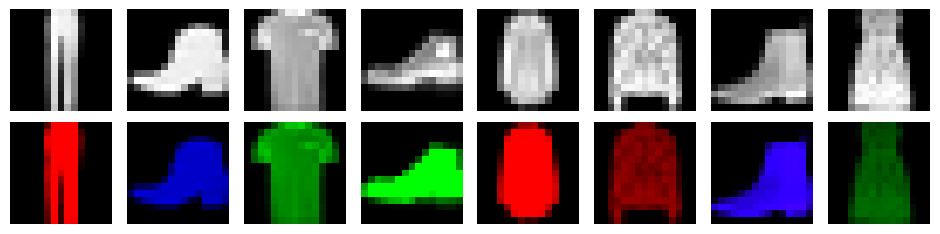

In [2]:
num_templates = 8
img_shape = (15, 15)
color_dim = 3
color_means = jnp.zeros((num_templates, color_dim))
color_var = jnp.array(1)
templates = generate_fashion_mnist_templates(
    num_templates=num_templates,
    template_shape=img_shape,
    flatten_templates=False,
)
gt_dist = ColoredSignalTemplateDistribution(
    color_means=color_means,
    color_var=color_var,
    templates=templates,
)
# Sample data
X, y = gt_dist.sample(key=jax.random.PRNGKey(22), num_samples=100)

# Visualize one example of each template
fig, axs = plt.subplots(2, num_templates, figsize=(9.5, 2.5))
for i in range(num_templates):
    # Find the first sample that uses template i
    sample_idx = jnp.where(y == i)[0][0]
    
    # Plot the sample
    templates_i = templates[i]
    axs[0, i].imshow(templates_i, cmap="gray")
    axs[0, i].axis("off")

    X_i =  X[sample_idx] # (X[sample_idx] - X[sample_idx].min()) / (X[sample_idx].max() - X[sample_idx].min())
    X_i = X_i.transpose(1, 2, 0)
    axs[1, i].imshow(X_i)
    axs[1, i].axis('off')
plt.tight_layout()
plt.show()
    


## Figure 6 (TODO: Fix when figure numbers are finalized)

In [19]:
from diffusion_mem_gen.constants import WANDB_PROJECT, WANDB_TEAM 
from diffusion_mem_gen.utils.wandb import read_wandb_config, download_files_from_runs, read_pkl, check_run_exists
from wandb import Api

wandb_experiment_group = f"data_colored_fashionmnist_model_shared_colored_fashionmnist_expt_varying_model_size_2025-05-14_23:10:37"

wandb_experiment = wandb_experiment_group + "_summary"
data_analysis_path = Path("./data_analysis")
data_analysis_path.mkdir(exist_ok=True, parents=True)

api = Api()
if not check_run_exists(api, WANDB_TEAM, WANDB_PROJECT, wandb_experiment):
    raise ValueError(f"Run {wandb_experiment} does not exist")

summary_paths = download_files_from_runs(api, WANDB_TEAM, WANDB_PROJECT, lambda run: run.name == wandb_experiment, file_filter_fn=lambda f: f.name == "results.pkl" or f.name == "config.yaml")

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with

Downloaded config.yaml to wandb_downloads/diffusion-edge-of-memorization/diffusion-mem-gen/data_colored_fashionmnist_model_shared_colored_fashionmnist_expt_varying_model_size_2025-05-14_23:10:37_summary/config.yaml
File results.pkl already exists at wandb_downloads/diffusion-edge-of-memorization/diffusion-mem-gen/data_colored_fashionmnist_model_shared_colored_fashionmnist_expt_varying_model_size_2025-05-14_23:10:37_summary/results.pkl. Skipping download.


In [44]:
run_id = list(summary_paths.keys())[0]
paths = summary_paths[run_id]
results_path = [p for p in paths if p.name == "results.pkl"][0]
config_path = [p for p in paths if p.name == "config.yaml"][0]
results  = read_pkl(results_path)
config = read_wandb_config(config_path)


In [48]:
from diffusionlab.dynamics import VariancePreservingProcess
from diffusionlab.schedulers import UniformScheduler
from diffusionlab.vector_fields import VectorFieldType
from diffusion_mem_gen.loss import loss_scaling

diffusion_process = VariancePreservingProcess()
scheduler = UniformScheduler()
eps_to_x0_weights = loss_scaling.loss_scaling_factor_factory(diffusion_process, VectorFieldType.EPS, VectorFieldType.X0)
snr = lambda t: (diffusion_process.alpha(t) / diffusion_process.sigma(t)) ** 2

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{gray}{RGB}{128,128,128}
\definecolor{teal1293165}{RGB}{12,93,165}

\begin{axis}[
tick pos=both,
title={Memorization Ratio},
x grid style={darkgray176},
xlabel={\(\displaystyle M/N\)},
xmin=0.055, xmax=1.045,
xtick style={color=black},
xtick={0,0.2,0.4,0.6,0.8,1,1.2},
xticklabels={
  \(\displaystyle {0.0}\),
  \(\displaystyle {0.2}\),
  \(\displaystyle {0.4}\),
  \(\displaystyle {0.6}\),
  \(\displaystyle {0.8}\),
  \(\displaystyle {1.0}\),
  \(\displaystyle {1.2}\)
},
y grid style={darkgray176},
ylabel={Ratio},
ymin=-0.0290000004693866, ymax=1.04900000002235,
ytick style={color=black},
ytick={-0.2,0,0.2,0.4,0.6,0.8,1,1.2},
yticklabels={
  \(\displaystyle {\ensuremath{-}0.2}\),
  \(\displaystyle {0.0}\),
  \(\displaystyle {0.2}\),
  \(\displaystyle {0.4}\),
  \(\displaystyle {0.6}\),
  \(\displaystyle {0.8}\),
  \(\displaystyle {1.0}\),
  \(\displaystyle {1.2}\

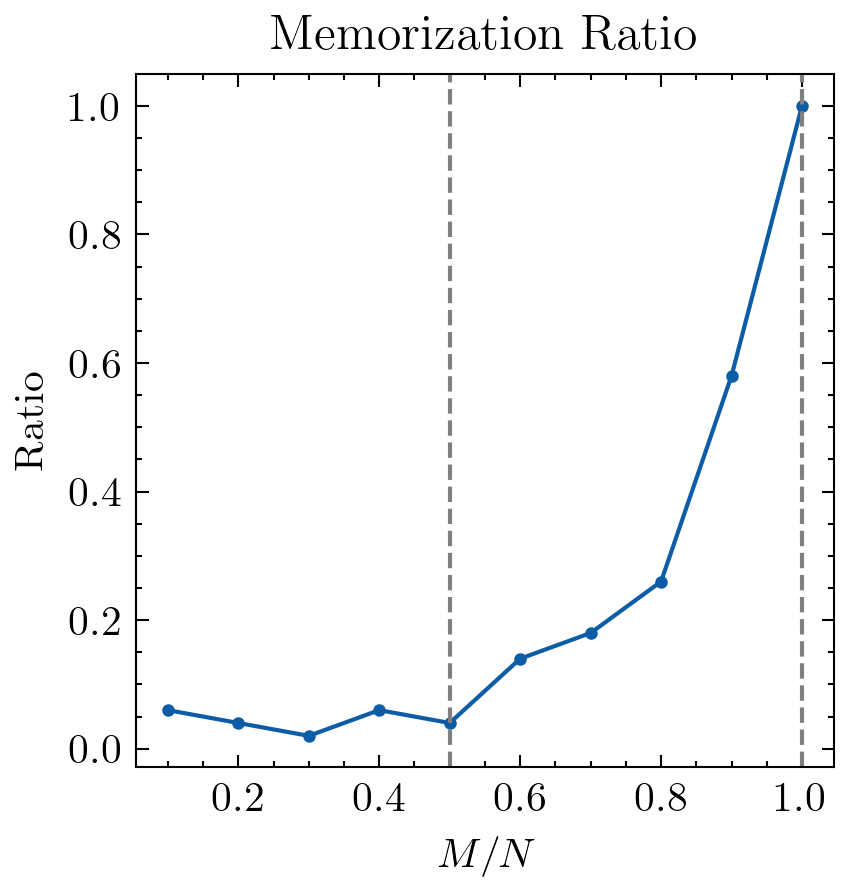

In [46]:
num_samples_train = config["num_samples_train"]["value"]
num_templates_train = sorted(list(results["trained"].keys()))
num_templates_eval = sorted(list(results["baselines"].keys()))

memorization_phase_transition_delta = 0.1
memorization_phase_transition_start = None
memorization_phase_transition_end = None
for i, m in enumerate(num_templates_train):
    if memorization_phase_transition_start is None and results["trained"][m]["memorization_ratio"] >= memorization_phase_transition_delta:
        assert memorization_phase_transition_end is None
        memorization_phase_transition_start = num_templates_train[i - 1] if i > 0 else m
    if memorization_phase_transition_end is None and results["trained"][m]["memorization_ratio"] >= 1 - memorization_phase_transition_delta:
        assert memorization_phase_transition_start is not None
        memorization_phase_transition_end = m
        break

plt.figure(figsize=(3, 3), dpi=300)
plt.style.use("science")

x_train = [u / num_samples_train for u in num_templates_train]
y = [results["trained"][m]["memorization_ratio"] for m in num_templates_train]
plt.plot(x_train, y, "-o", markersize=2, label="Memorization Ratio")
plt.axvline(x=memorization_phase_transition_start / num_samples_train, color="gray", linestyle="--")
plt.axvline(x=memorization_phase_transition_end / num_samples_train, color="gray", linestyle="--")
plt.title("Memorization Ratio")
plt.xlabel(r"$M/N$")
plt.ylabel("Ratio")
print(get_tikz_code())
plt.show()


<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3628103/3071621386.py:50: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f"Training Loss, $\psi={snr(t):.3f}$", fontsize=20)


% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{goldenrod}{RGB}{218,165,32}
\definecolor{gray}{RGB}{128,128,128}
\definecolor{green}{RGB}{0,128,0}

\begin{axis}[
legend cell align={left},
legend style={
  fill opacity=0.8,
  draw opacity=1,
  text opacity=1,
  at={(0.03,0.03)},
  anchor=south west,
  draw=none
},
log basis y={10},
tick pos=both,
title={Training Loss, \(\displaystyle \psi=6.704\)},
x grid style={darkgray176},
xlabel={\(\displaystyle M/N\)},
xmin=-0.029, xmax=1.049,
xtick style={color=black},
xtick={-0.2,0,0.2,0.4,0.6,0.8,1,1.2},
xticklabels={
  \(\displaystyle {\ensuremath{-}0.2}\),
  \(\displaystyle {0.0}\),
  \(\displaystyle {0.2}\),
  \(\displaystyle {0.4}\),
  \(\displaystyle {0.6}\),
  \(\displaystyle {0.8}\),
  \(\displaystyle {1.0}\),
  \(\displaystyle {1.2}\)
},
y grid style={darkgray176},
ylabel={\(\displaystyle \mathcal{L}_{N, t}\)},
ymin=0.00116688282153916, ymax=522.556210894483,

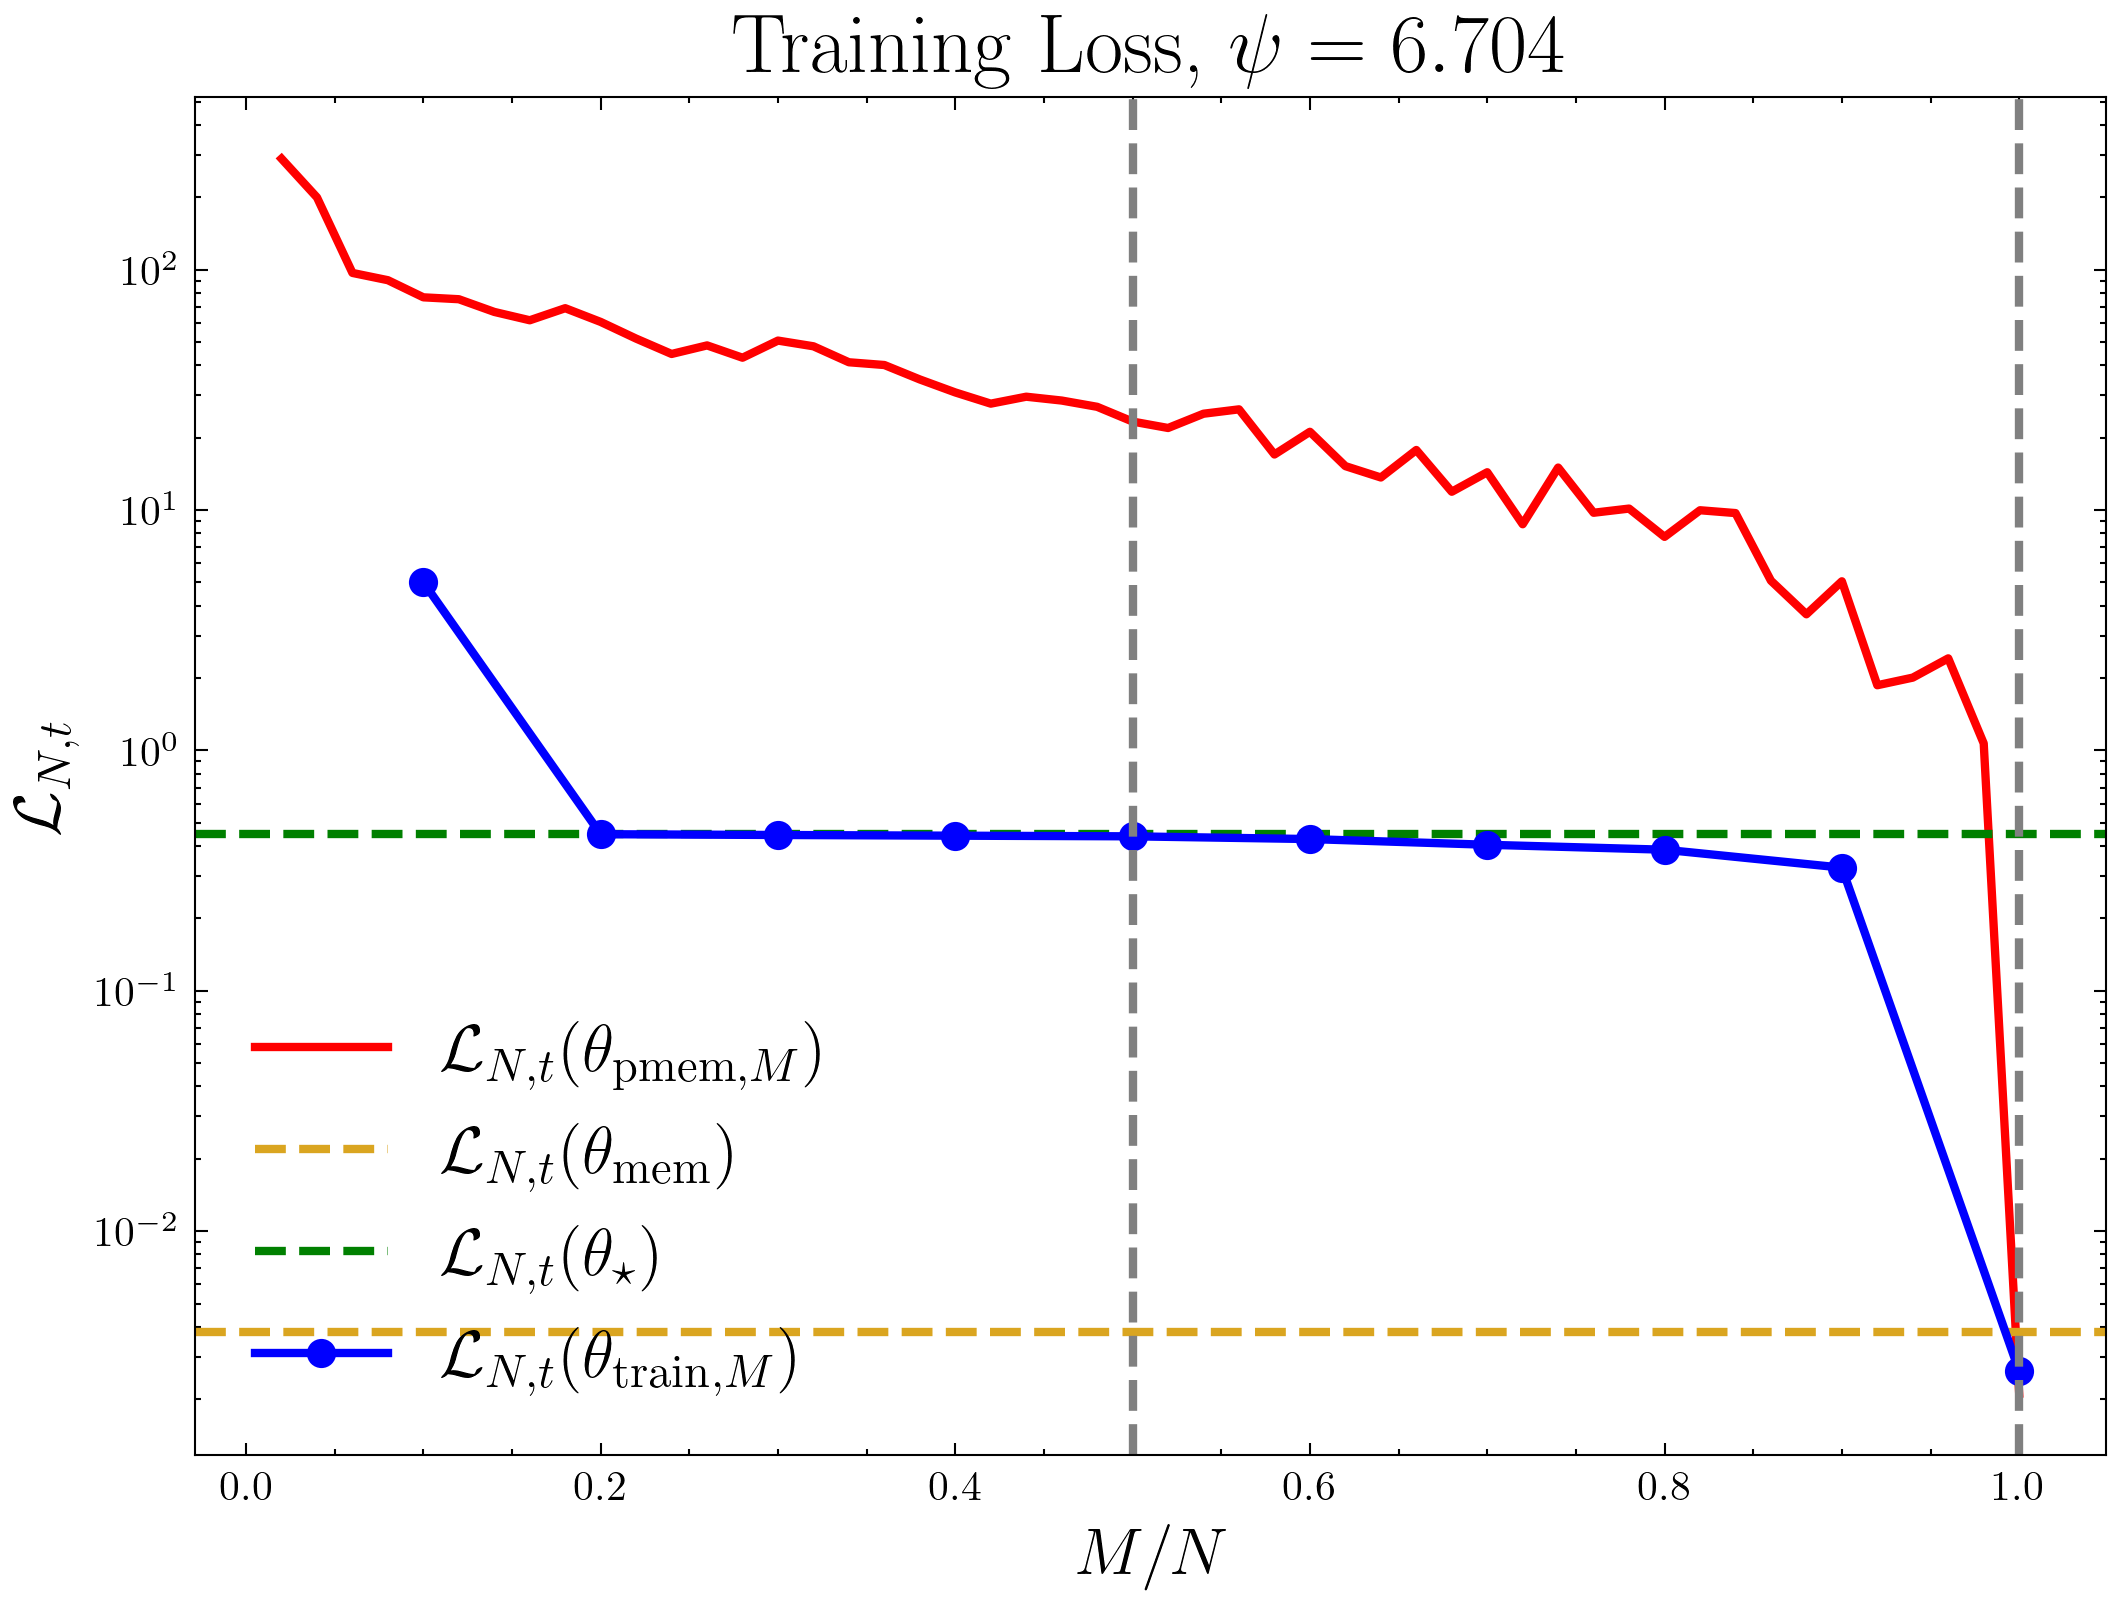

In [55]:
num_samples_train = config["num_samples_train"]["value"]
num_templates_train = sorted(list(results["trained"].keys()))
num_templates_eval = sorted(list(results["baselines"].keys()))

memorization_phase_transition_delta = 0.1
memorization_phase_transition_start = None
memorization_phase_transition_end = None
for i, m in enumerate(num_templates_train):
    if memorization_phase_transition_start is None and results["trained"][m]["memorization_ratio"] >= memorization_phase_transition_delta:
        assert memorization_phase_transition_end is None
        memorization_phase_transition_start = num_templates_train[i - 1] if i > 0 else m
    if memorization_phase_transition_end is None and results["trained"][m]["memorization_ratio"] >= 1 - memorization_phase_transition_delta:
        assert memorization_phase_transition_start is not None
        memorization_phase_transition_end = m
        break


img_shape = config["img_shape"]["value"]
gt_color_var = config["gt_color_var_scale"]["value"]
num_samples_train = config["num_samples_train"]["value"]
t_min = config["t_min"]["value"]
t_max = config["t_max"]["value"]
num_times = config["num_times"]["value"]
num_gt_templates= config["gt_num_templates"]["value"]
ts = scheduler.get_ts(t_min=t_min, t_max=t_max, num_steps=num_times - 1)

# i = 20  # t = 0.201
i = 16  # t = 0.360
t = ts[i]
plt.figure(figsize=(7, 5), dpi=300)
plt.style.use("science")

y_train = [results["trained"][m]["train_loss"][i]["trained"] * eps_to_x0_weights(t) for m in num_templates_train]
y_pmem = [results["baselines"][m]["train_loss"][i]["partial_mem"] * eps_to_x0_weights(t) for m in num_templates_eval]
y_gt = results["baselines"][num_templates_eval[0]]["train_loss"][i]["ground_truth"] * eps_to_x0_weights(t)
y_mem = results["baselines"][num_templates_eval[0]]["train_loss"][i]["memorizing"] * eps_to_x0_weights(t)

plt.plot([u / num_samples_train for u in num_templates_eval], y_pmem, linewidth=2, color="red", label=r"$\mathcal{L}_{N, t}(\theta_{\mathrm{pmem}, M})$")

plt.axhline(y=y_mem, linestyle="--", linewidth=2, color="goldenrod", label=r"$\mathcal{L}_{N, t}(\theta_{\mathrm{mem}})$")

plt.axhline(y=y_gt, linestyle="--", linewidth=2, color="green", label=r"$\mathcal{L}_{N, t}(\theta_{\star})$")
plt.plot([u / num_samples_train for u in num_templates_train], y_train, marker="o", linewidth=2, color="blue", label=r"$\mathcal{L}_{N, t}(\theta_{\mathrm{train}, M})$")
plt.axvline(x=memorization_phase_transition_start/num_samples_train, linestyle="--", linewidth=2, color="gray")#, label="PT Start")
plt.axvline(x=memorization_phase_transition_end/num_samples_train, linestyle="--", linewidth=2, color="gray")#, label="PT End")

plt.yscale("log")
plt.legend(fontsize=16)
plt.tight_layout()
plt.title(f"Training Loss, $\psi={snr(t):.3f}$", fontsize=20)
plt.xlabel(r"$M/N$", fontsize=16)
plt.ylabel(r"$\mathcal{L}_{N, t}$", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
print(get_tikz_code())
plt.show()

<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3628103/1760772884.py:50: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f"Test Loss, $\psi={snr(t):.3f}$", fontsize=20)


% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{goldenrod}{RGB}{218,165,32}
\definecolor{gray}{RGB}{128,128,128}
\definecolor{green}{RGB}{0,128,0}

\begin{axis}[
legend cell align={left},
legend style={
  fill opacity=0.8,
  draw opacity=1,
  text opacity=1,
  at={(0.5,0.5)},
  anchor=center,
  draw=none
},
log basis y={10},
tick pos=both,
title={Test Loss, \(\displaystyle \psi=6.704\)},
x grid style={darkgray176},
xlabel={\(\displaystyle M/N\)},
xmin=-0.029, xmax=1.049,
xtick style={color=black},
xtick={-0.2,0,0.2,0.4,0.6,0.8,1,1.2},
xticklabels={
  \(\displaystyle {\ensuremath{-}0.2}\),
  \(\displaystyle {0.0}\),
  \(\displaystyle {0.2}\),
  \(\displaystyle {0.4}\),
  \(\displaystyle {0.6}\),
  \(\displaystyle {0.8}\),
  \(\displaystyle {1.0}\),
  \(\displaystyle {1.2}\)
},
y grid style={darkgray176},
ylabel={\(\displaystyle \mathcal{L}_{t}\)},
ymin=0.323810038410463, ymax=439.484048695223,
ymode=log,
yti

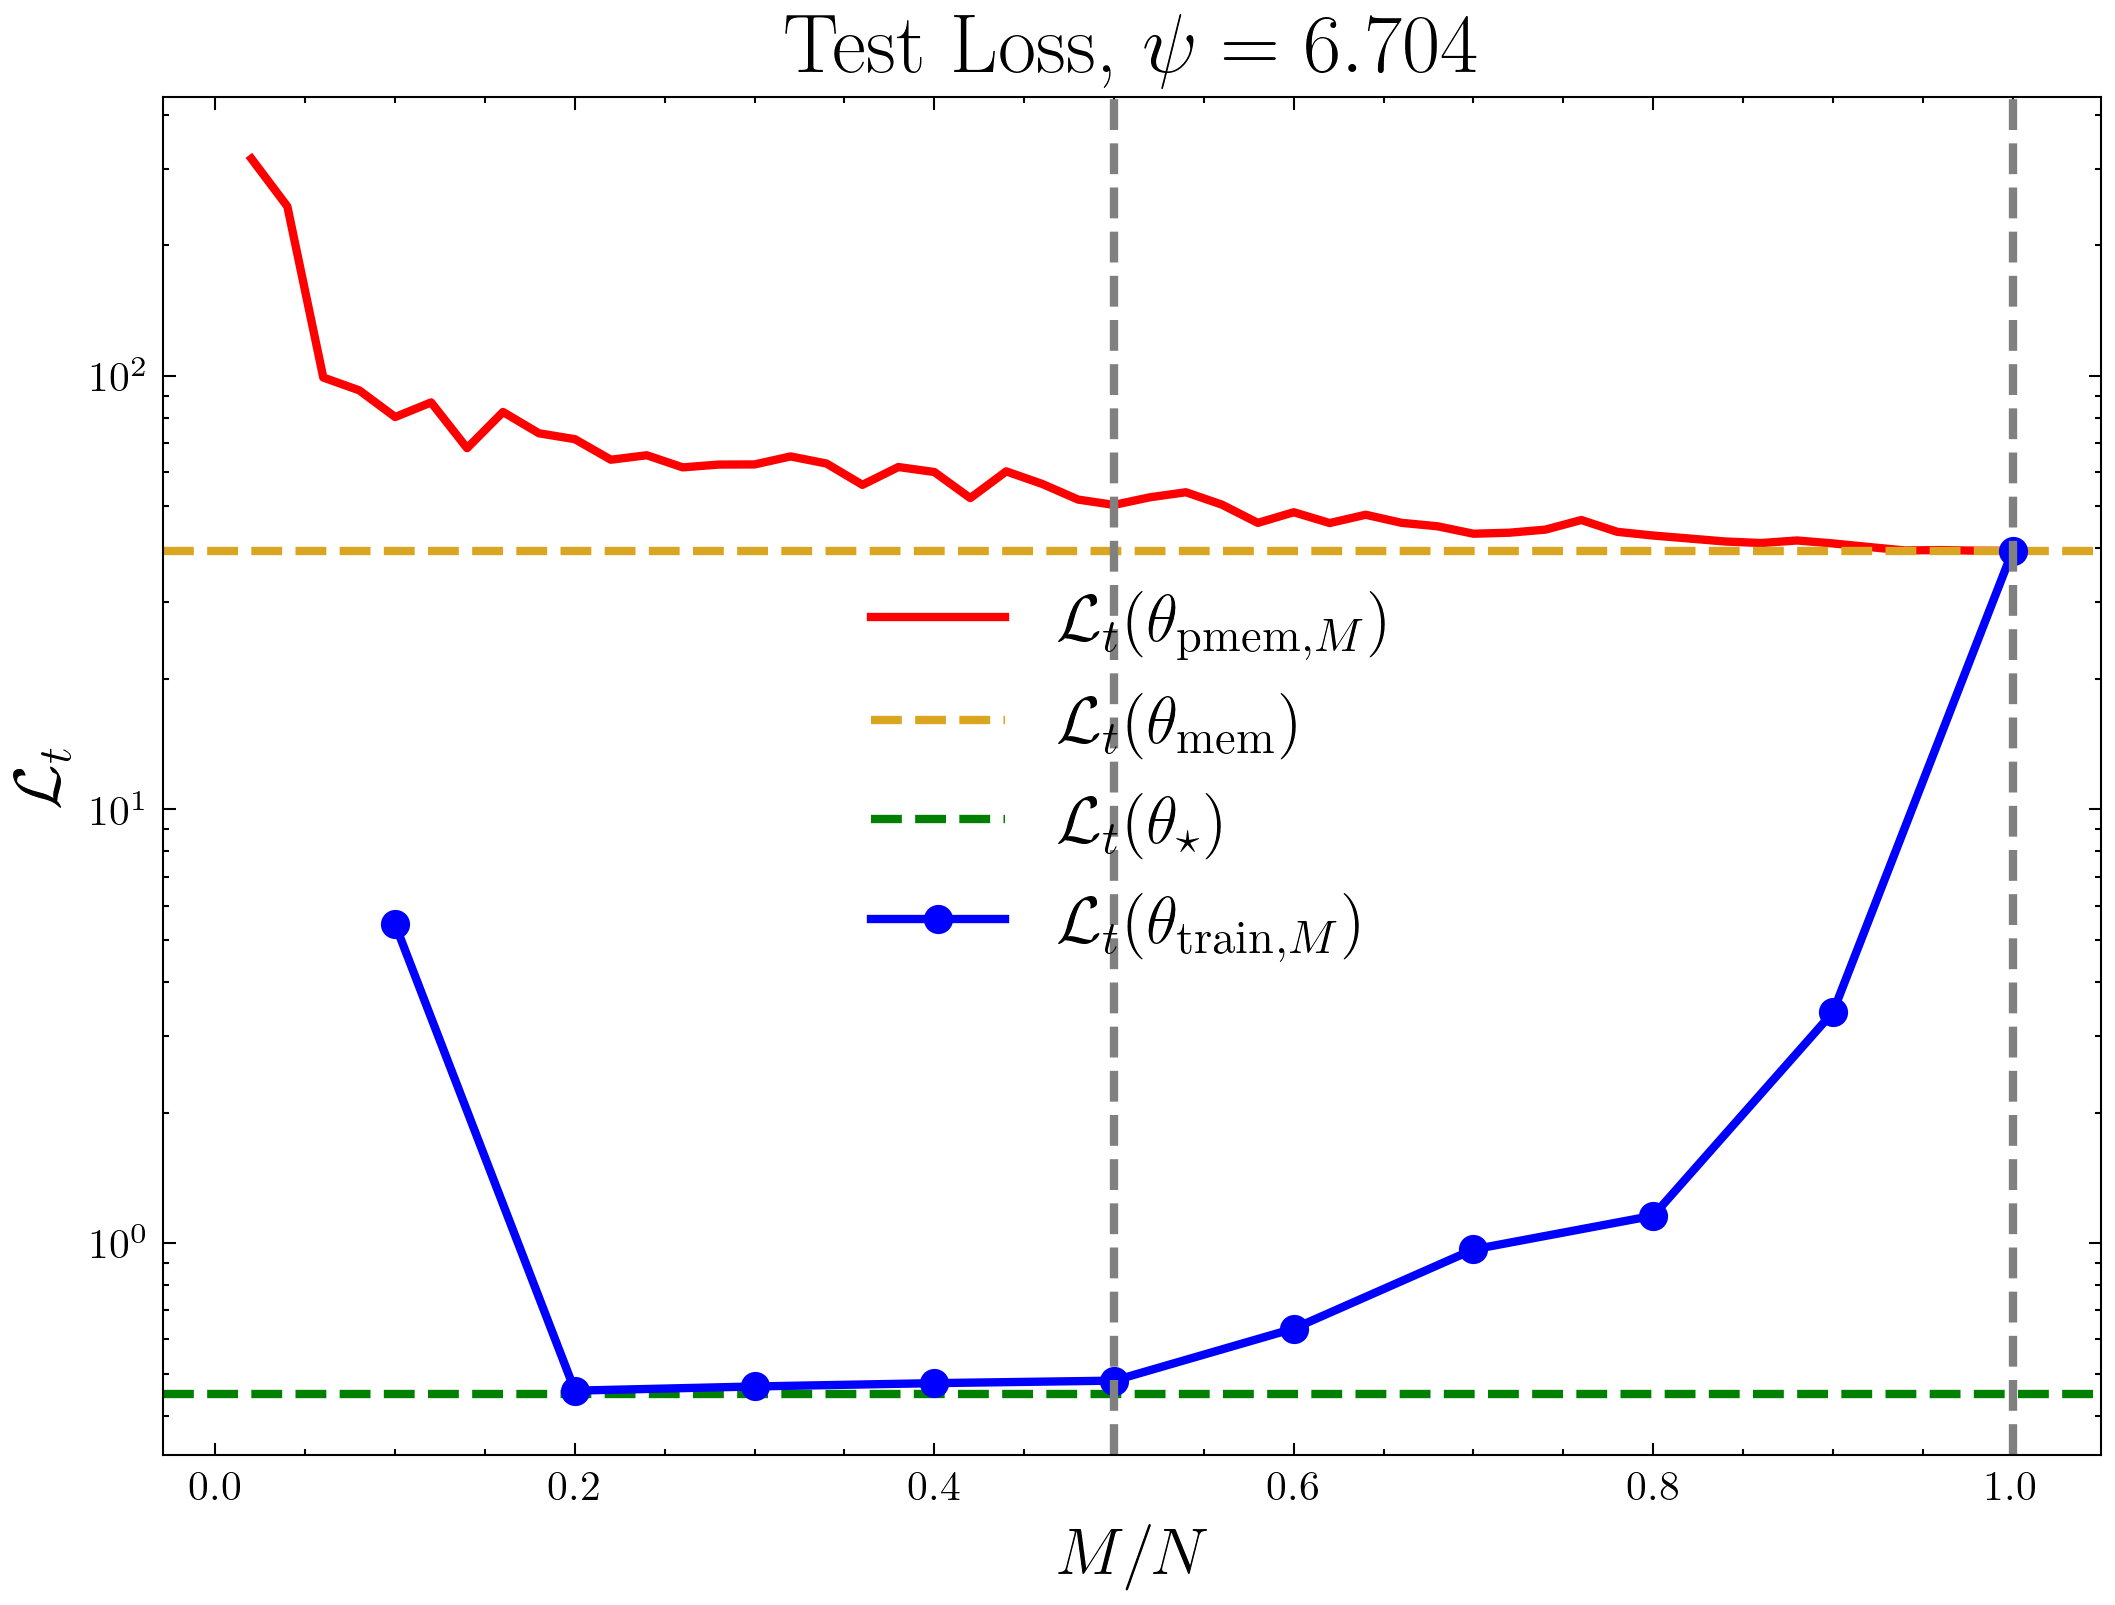

In [56]:
num_samples_train = config["num_samples_train"]["value"]
num_templates_train = sorted(list(results["trained"].keys()))
num_templates_eval = sorted(list(results["baselines"].keys()))

memorization_phase_transition_delta = 0.1
memorization_phase_transition_start = None
memorization_phase_transition_end = None
for i, m in enumerate(num_templates_train):
    if memorization_phase_transition_start is None and results["trained"][m]["memorization_ratio"] >= memorization_phase_transition_delta:
        assert memorization_phase_transition_end is None
        memorization_phase_transition_start = num_templates_train[i - 1] if i > 0 else m
    if memorization_phase_transition_end is None and results["trained"][m]["memorization_ratio"] >= 1 - memorization_phase_transition_delta:
        assert memorization_phase_transition_start is not None
        memorization_phase_transition_end = m
        break


img_shape = config["img_shape"]["value"]
gt_color_var = config["gt_color_var_scale"]["value"]
num_samples_train = config["num_samples_train"]["value"]
t_min = config["t_min"]["value"]
t_max = config["t_max"]["value"]
num_times = config["num_times"]["value"]
num_gt_templates= config["gt_num_templates"]["value"]
ts = scheduler.get_ts(t_min=t_min, t_max=t_max, num_steps=num_times - 1)

# i = 20  # t = 0.201
i = 16  # t = 0.360
t = ts[i]
plt.figure(figsize=(7, 5), dpi=300)
plt.style.use("science")

y_train = [results["trained"][m]["val_loss"][i]["trained"] * eps_to_x0_weights(t) for m in num_templates_train]
y_pmem = [results["baselines"][m]["val_loss"][i]["partial_mem"] * eps_to_x0_weights(t) for m in num_templates_eval]
y_gt = results["baselines"][num_templates_eval[0]]["val_loss"][i]["ground_truth"] * eps_to_x0_weights(t)
y_mem = results["baselines"][num_templates_eval[0]]["val_loss"][i]["memorizing"] * eps_to_x0_weights(t)

plt.plot([u / num_samples_train for u in num_templates_eval], y_pmem, linewidth=2, color="red", label=r"$\mathcal{L}_{t}(\theta_{\mathrm{pmem}, M})$")

plt.axhline(y=y_mem, linestyle="--", linewidth=2, color="goldenrod", label=r"$\mathcal{L}_{t}(\theta_{\mathrm{mem}})$")

plt.axhline(y=y_gt, linestyle="--", linewidth=2, color="green", label=r"$\mathcal{L}_{t}(\theta_{\star})$")
plt.plot([u / num_samples_train for u in num_templates_train], y_train, marker="o", linewidth=2, color="blue", label=r"$\mathcal{L}_{t}(\theta_{\mathrm{train}, M})$")
plt.axvline(x=memorization_phase_transition_start/num_samples_train, linestyle="--", linewidth=2, color="gray")#, label="PT Start")
plt.axvline(x=memorization_phase_transition_end/num_samples_train, linestyle="--", linewidth=2, color="gray")#, label="PT End")

plt.yscale("log")
plt.legend(fontsize=16)
plt.tight_layout()
plt.title(f"Test Loss, $\psi={snr(t):.3f}$", fontsize=20)
plt.xlabel(r"$M/N$", fontsize=16)
plt.ylabel(r"$\mathcal{L}_{t}$", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
print(get_tikz_code())
plt.show()